# Feature Importance (Classifier) - Integrated Gradients

This notebook analyzes the **fine-tuned Sequence Classifier** (Med-Gemma) to understand which tokens contribute to a specific cancer type prediction.

In [2]:
import os
import sys
import torch
import joblib
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from peft import PeftModel

sys.path.append(os.path.abspath('..'))

from src.interpretability.feature_importance.integrated_gradients_classifier import ClassifierIG
from src.interpretability.viz.utils import plot_token_importance, plot_text_heatmap

%matplotlib inline

## 1. Load Model & Label Encoder

In [3]:
CHECKPOINT_DIR = "../checkpoints/classifier_run/final_model"
BASE_MODEL = "google/medgemma-1.5-4b-it"
LABEL_ENCODER_PATH = os.path.join(os.path.dirname(CHECKPOINT_DIR), "label_encoder.joblib")

print("Loading Label Encoder...")
label_encoder = joblib.load(LABEL_ENCODER_PATH)
class_names = label_encoder.classes_.tolist()
num_labels = len(class_names)
print(f"Classes ({num_labels}): {class_names}")

print(f"Loading Tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)

print(f"Loading Base Model: {BASE_MODEL}...")
base_model = AutoModelForSequenceClassification.from_pretrained(
    BASE_MODEL,
    num_labels=num_labels,
    id2label={i: c for i, c in enumerate(class_names)},
    label2id={c: i for i, c in enumerate(class_names)},
    dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
base_model.config.pad_token_id = tokenizer.pad_token_id

print(f"Loading LoRA Adapter from {CHECKPOINT_DIR}...")
model = PeftModel.from_pretrained(base_model, CHECKPOINT_DIR)
model.eval()
print("Model Loaded!")

Loading Label Encoder...
Classes (20): ['BLCA', 'BRCA', 'CESC', 'COAD', 'GBM', 'HNSC', 'KIRC', 'KIRP', 'LGG', 'LIHC', 'LUAD', 'LUSC', 'OV', 'PRAD', 'SARC', 'SKCM', 'STAD', 'TGCT', 'THCA', 'UCEC']
Loading Tokenizer...
Loading Base Model: google/medgemma-1.5-4b-it...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of Gemma3ForSequenceClassification were not initialized from the model checkpoint at google/medgemma-1.5-4b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loading LoRA Adapter from ../checkpoints/classifier_run/final_model...
Model Loaded!


## 2. Load Sample Data

In [ ]:
test_df = pd.read_csv("../tcga_reports_valid.csv").sample(5, random_state=42)
#pick random sample using random number generator
sample = test_df.iloc[np.random.randint(0, len(test_df))]
text = sample['text']
true_label = sample['cancer_type']
print(f"True Label: {true_label}")
print(f"Text Snippet: {text[:200]}...")

True Label: TGCT
Text Snippet: Research Gross Description. Research Dx. Right testicle, orchiectomy. Seminoma. See case summary. CASE SUMMARY FOR TESTIS (RADICAL ORCHIECTOMY): Tumor focality: Multifocal. Tumor size: Greatest dimens...


## 3. Run Integrated Gradients

Target Class Index: 17 (TGCT)


Gemma3ForSequenceClassification will not detect padding tokens in `inputs_embeds`. Results may be unexpected if using padding tokens in conjunction with `inputs_embeds.`


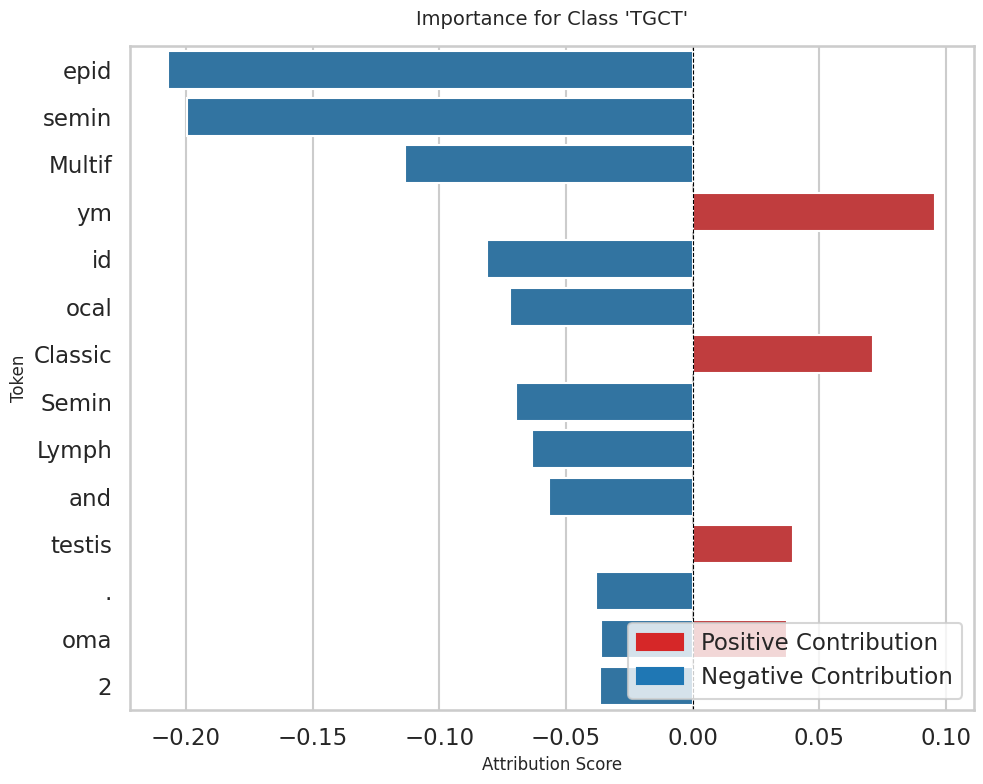

In [4]:
# Initialize Interpreter
cig = ClassifierIG(model, tokenizer)

# Determine target class index (e.g., the true label, or a predicted label)
target_idx = label_encoder.transform([true_label])[0]
print(f"Target Class Index: {target_idx} ({true_label})")

# Run Interpretation
# Using fewer steps for speed in notebook; increase for better accuracy
res = cig.interpret(text, target_class_idx=target_idx, n_steps=20)

# Visualize
plot_token_importance(res['tokens'], res['scores'], title=f"Importance for Class '{true_label}'")

In [ ]:
from IPython.core.display import display, HTML

# Visualize Heatmap
plot_text_heatmap(res['tokens'], res['scores'])


Stats: Min=-0.8992, Max=0.0980, Mean=-0.0026


/tmp/ipykernel_3604299/942443024.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


: 

True Label: SARC
Text Snippet: Clinical Diagnosis & History: Patient with left paraspinal spindle cell neoplasm. Specimens Submitted: 1: SP: Left paraspinal mass. 2: SP: Normal fat. DIAGNOSIS: 1). SOFT TISSUE, LEFT PARASPINAL; EXCI...
Target Class Index: 14 (SARC)


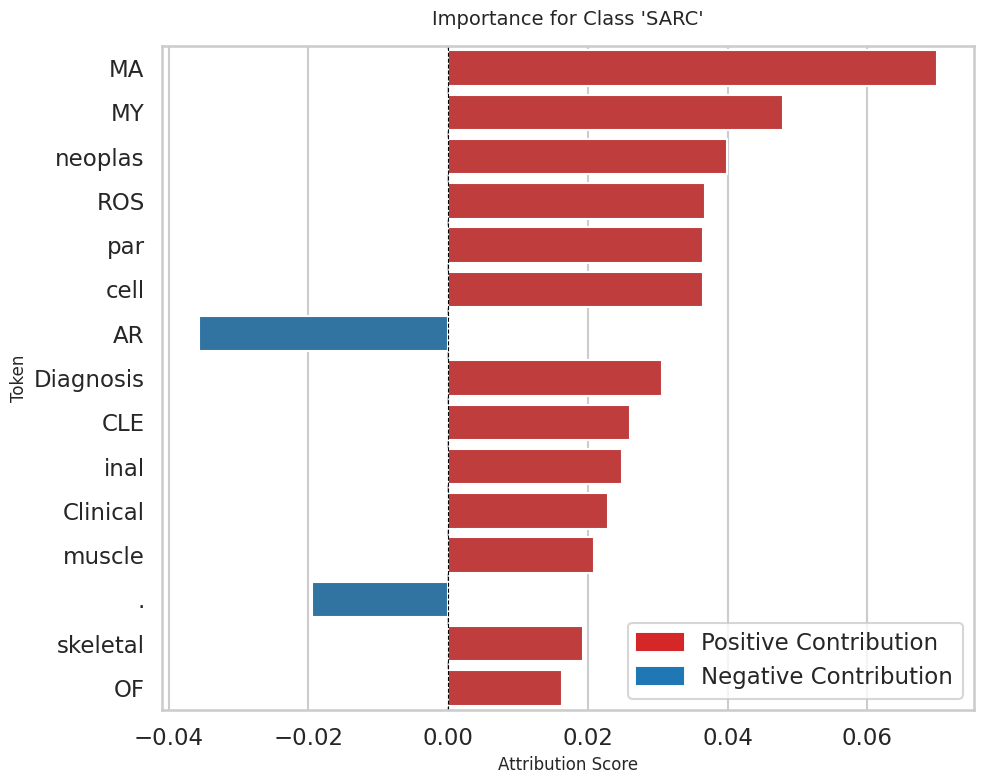

Stats: Min=-0.9857, Max=0.0700, Mean=-0.0007


/tmp/ipykernel_3705633/3314881815.py:28: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [8]:
test_df = pd.read_csv("../tcga_reports_valid.csv")
#pick random sample using random number generator
sample = test_df.iloc[np.random.randint(0, len(test_df))]
text = sample['text']
true_label = sample['cancer_type']
print(f"True Label: {true_label}")
print(f"Text Snippet: {text[:200]}...")




# Initialize Interpreter
cig = ClassifierIG(model, tokenizer)

# Determine target class index (e.g., the true label, or a predicted label)
target_idx = label_encoder.transform([true_label])[0]
print(f"Target Class Index: {target_idx} ({true_label})")

# Run Interpretation
# Using fewer steps for speed in notebook; increase for better accuracy
res = cig.interpret(text, target_class_idx=target_idx, n_steps=20)

# Visualize
plot_token_importance(res['tokens'], res['scores'], title=f"Importance for Class '{true_label}'")



from IPython.core.display import display, HTML

# Visualize Heatmap
plot_text_heatmap(res['tokens'], res['scores'])
